
#***CAPSTONE DESIGN: PREDICT THE DEMAND OF USING BIKES IN AN URBAN AREA***
*4/2023*

>***The goal of this project is to see the effects of environment factors on using bikes.*** 
>>***This dataset from Kaggle includes weather information (Temperature, Humidity, Windspeed, Visibility, Dewpoint, Solar radiation, Snowfall, Rainfall), the number of bikes rented per hour and date information.***
>> ***https://bom.so/wcdpIO***



##***1.Import libraries and dataset***

In [ ]:
import numpy as np
import pandas as pd
import re
from typing import Tuple, Type

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'DejaVu Sans'  # Or any other font that supports Georgian script


from sklearn import preprocessing
from sklearn.decomposition import PCA
from scipy.stats import chi2_contingency
import statsmodels.api as sm

# Clustering
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture

# Regression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import svm
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel


# For execution time calculation
from datetime import datetime
from datetime import timedelta
import random
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
bike_demand = pd.read_csv('https://raw.githubusercontent.com/LePhongCongThanh/Predict-Demand-of-Using-Bikes-in-An-Urban/main/SeoulBikeData.csv', encoding= 'unicode_escape')
bike_demand.info()
bike_demand.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       8760 non-null   object 
 1   Rented Bike Count          8760 non-null   int64  
 2   Hour                       8760 non-null   int64  
 3   Temperature(°C)            8760 non-null   float64
 4   Humidity(%)                8760 non-null   int64  
 5   Wind speed (m/s)           8760 non-null   float64
 6   Visibility (10m)           8760 non-null   int64  
 7   Dew point temperature(°C)  8760 non-null   float64
 8   Solar Radiation (MJ/m2)    8760 non-null   float64
 9   Rainfall(mm)               8760 non-null   float64
 10  Snowfall (cm)              8760 non-null   float64
 11  Seasons                    8760 non-null   object 
 12  Holiday                    8760 non-null   object 
 13  Functioning Day            8760 non-null   objec

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


>*This dataset has a shape of 8760 rows(observations) X 14 columns(features).*

>*Therein, there are 10 features of numeric dtype (int, float) and 4 features of categorical dtype (object).*

>>*However, the feature of "Date" can be transformed from "object" into "date" dtype. This transformation will be performed after checking missing values (completed in 2.1.2).*

>>*This dataset does not include "ID" column that is very important to identify uniquely each observation. Thus, the Index will be set as a "ID" column (completed in 2.1.2).*

>>*Moreover, the info of this dataset shows that there are no features having missing values, but this is only right with features of numeric datatypes. For features of object dtype may have misssing values of shape of "-", ".",... Thus, it's needed to check carefully features of object dtype (completed in 2.1.1).*

##***2. Data pre-processing***


###***2.1 Data cleaning***

###***2.1.1 Missing Values***

In [ ]:
# Select columns of object dtypes
cols_object = bike_demand.select_dtypes(include=['object']).columns.to_list()

# Loop through each cols_object
for col in cols_object:
  value_counts = bike_demand[col].value_counts().sort_index()
  print(f'Values of {col} are:')
  print(value_counts)

Values of Date are:
01/01/2018    24
01/02/2018    24
01/03/2018    24
01/04/2018    24
01/05/2018    24
              ..
31/05/2018    24
31/07/2018    24
31/08/2018    24
31/10/2018    24
31/12/2017    24
Name: Date, Length: 365, dtype: int64
Values of Seasons are:
Autumn    2184
Spring    2208
Summer    2208
Winter    2160
Name: Seasons, dtype: int64
Values of Holiday are:
Holiday        432
No Holiday    8328
Name: Holiday, dtype: int64
Values of Functioning Day are:
No      295
Yes    8465
Name: Functioning Day, dtype: int64


>*Use method "sort_index()" to filter missing values having shapes of  "-","..." , but there are no values like that. Thus, it can conclude that there are really no missing values in "object" cols.*

>*For numeric cols, the info shows that these cols have 8760 non-null values and dtypes of numeric (int, float). From this, it's enough to conclude that there are certainly no missing value in num cols without checking carefully like object cols.*

###***2.1.2 Set ID column and tranform dtype of Date column***

In [ ]:
# Add "ID" column and move column "ID" to the first position
def transform_add(df: pd.DataFrame) -> pd.DataFrame:
  df["ID"] = df.index # add "ID" col at the last postion
  col_ID = df.pop("ID") # remove column "ID" and return as a Series object
  df.insert(0, "ID", col_ID) # insert the Series object as column 0
  df["Date"] = df["Date"].astype("datetime64") #transform datetime
  return df.info(), df.head()
transform_add(bike_demand)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   ID                         8760 non-null   int64         
 1   Date                       8760 non-null   datetime64[ns]
 2   Rented Bike Count          8760 non-null   int64         
 3   Hour                       8760 non-null   int64         
 4   Temperature(°C)            8760 non-null   float64       
 5   Humidity(%)                8760 non-null   int64         
 6   Wind speed (m/s)           8760 non-null   float64       
 7   Visibility (10m)           8760 non-null   int64         
 8   Dew point temperature(°C)  8760 non-null   float64       
 9   Solar Radiation (MJ/m2)    8760 non-null   float64       
 10  Rainfall(mm)               8760 non-null   float64       
 11  Snowfall (cm)              8760 non-null   float64       
 12  Season

<ipython-input-5-4fbcbfded1d6>:6: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df["Date"] = df["Date"].astype("datetime64") #transform datetime


(None,
    ID       Date  Rented Bike Count  Hour  Temperature(°C)  Humidity(%)  \
 0   0 2017-01-12                254     0             -5.2           37   
 1   1 2017-01-12                204     1             -5.5           38   
 2   2 2017-01-12                173     2             -6.0           39   
 3   3 2017-01-12                107     3             -6.2           40   
 4   4 2017-01-12                 78     4             -6.0           36   
 
    Wind speed (m/s)  Visibility (10m)  Dew point temperature(°C)  \
 0               2.2              2000                      -17.6   
 1               0.8              2000                      -17.6   
 2               1.0              2000                      -17.7   
 3               0.9              2000                      -17.6   
 4               2.3              2000                      -18.6   
 
    Solar Radiation (MJ/m2)  Rainfall(mm)  Snowfall (cm) Seasons     Holiday  \
 0                      0.0           0

>*ID column has been added at the first position and dtype of date col has been transformed*

###***2.1.3 Check value counts of object cols*** 

>*It's needed to check values of each cols. At least, values of each column are reasonable with the its title.*  

In [ ]:
# Split cols into 2 types of col
object_col = bike_demand.select_dtypes(include="object")
num_col = bike_demand.select_dtypes(include=['float64', 'int64'])

# Loop through cols
for col in object_col.columns.to_list(): 
  values = bike_demand[col].value_counts().sort_values(ascending=True)
  print(f'values of {col} are:')
  print(values)

values of Seasons are:
Winter    2160
Autumn    2184
Spring    2208
Summer    2208
Name: Seasons, dtype: int64
values of Holiday are:
Holiday        432
No Holiday    8328
Name: Holiday, dtype: int64
values of Functioning Day are:
No      295
Yes    8465
Name: Functioning Day, dtype: int64


>*The values of cols of object dtypes are match with its title*

<ipython-input-7-45a7c635c212>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(counts.index);
<ipython-input-7-45a7c635c212>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(counts.index);
<ipython-input-7-45a7c635c212>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(counts.index);


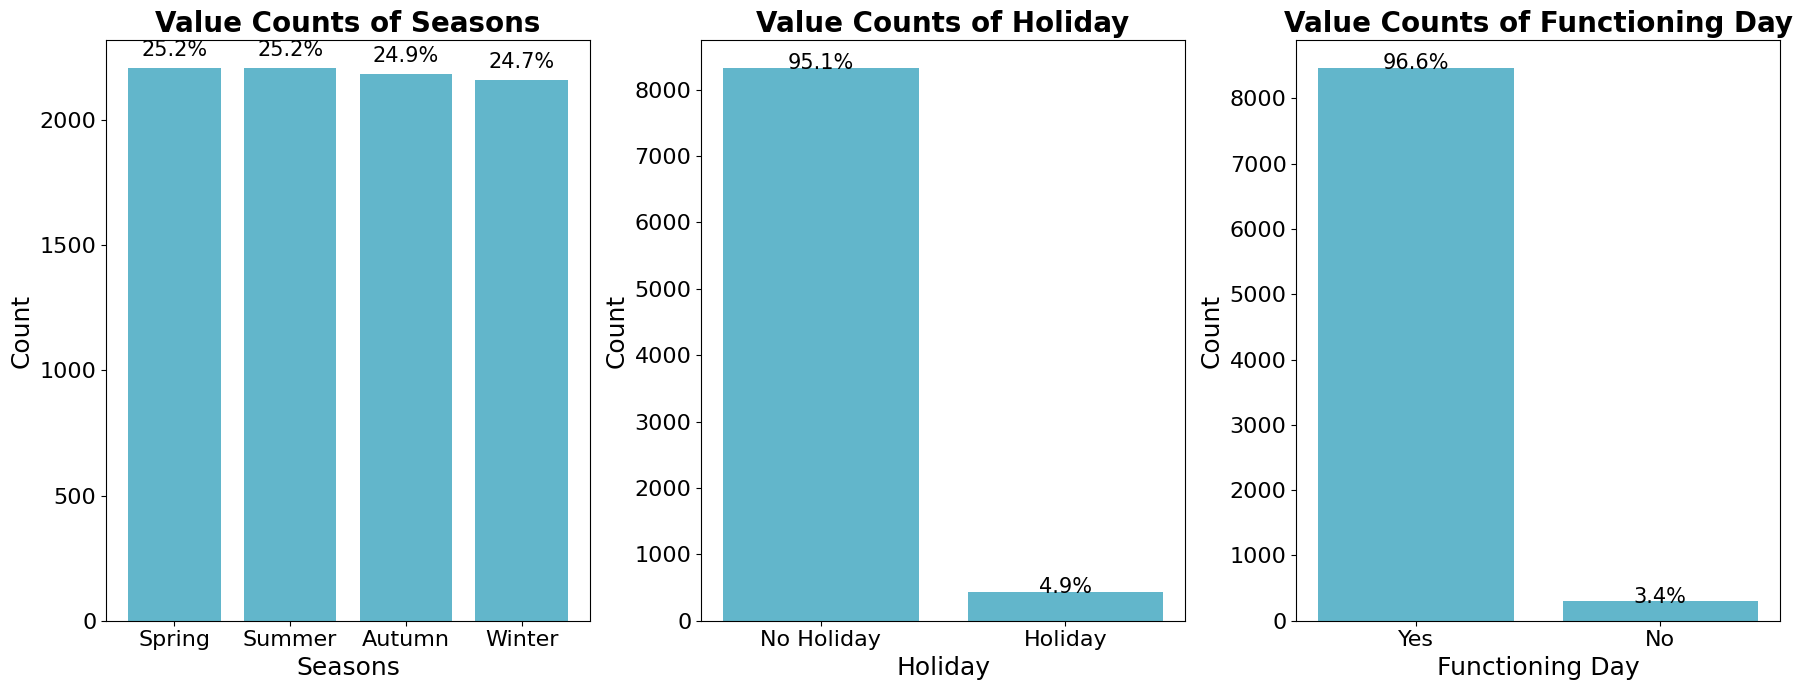

In [ ]:

# Create a figure and subplots
fig, axes = plt.subplots(1,3, figsize=(18, 7))
axes = axes.flatten()

# Loop through each column in the dataframe
for i, col in enumerate(object_col.columns.to_list()):
    counts = bike_demand[col].value_counts()  # Get the value counts for the column
    ax = axes[i]  # Get the subplot
    ax.bar(counts.index, counts.values, color='#62b6cb')  # Create a bar chart of the counts
    ax.set_title(f'Value Counts of {col}', fontsize=20, fontweight='bold')  # Add a title to the subplot
    ax.set_xlabel(col, fontsize=18)  # Add a label to the x-axis
    ax.set_ylabel('Count', fontsize=18)  # Add a label to the y-axis
    ax.set_xticklabels(counts.index);
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
     # Add percentage labels to the bars
    for j, count in enumerate(counts):
        ax.text(j, count+0.008*counts.sum(), f"{count/counts.sum()*100:.1f}%", ha="center", va="center", fontsize=15)

# Adjust the spacing of the subplots
fig.tight_layout()


# Show the plot
plt.show();

###***2.1.4 Statistical description and values of numerical columns***

In [ ]:
# Check col of Datetime dtype
bike_demand['Date'].value_counts().sort_values()
bike_demand['Date'].value_counts().value_counts()
bike_demand['Hour'].value_counts()

2017-01-12    24
2017-05-12    24
2017-06-12    24
2017-07-12    24
2017-08-12    24
              ..
2018-11-29    24
2018-10-11    24
2018-03-09    24
2018-07-11    24
2018-11-30    24
Name: Date, Length: 365, dtype: int64

0     365
1     365
22    365
21    365
20    365
19    365
18    365
17    365
16    365
15    365
14    365
13    365
12    365
11    365
10    365
9     365
8     365
7     365
6     365
5     365
4     365
3     365
2     365
23    365
Name: Hour, dtype: int64

24    365
Name: Date, dtype: int64

>*ThIs output shows that this dataset is recorded within 365 days from 2017-1-12 to 2018-30-11. and each day was recorded in 24 times correspoding to 24 hours each day.*

In [ ]:
num_col.drop(columns='ID').describe().round(2)

,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm)
count,8760.00,8760.00,8760.00,8760.00,8760.00,8760.00,8760.00,8760.00,8760.00,8760.00
mean,704.60,11.50,12.88,58.23,1.72,1436.83,4.07,0.57,0.15,0.08
std,645.00,6.92,11.94,20.36,1.04,608.30,13.06,0.87,1.13,0.44
min,0.00,0.00,-17.80,0.00,0.00,27.00,-30.60,0.00,0.00,0.00
25%,191.00,5.75,3.50,42.00,0.90,940.00,-4.70,0.00,0.00,0.00
50%,504.50,11.50,13.70,57.00,1.50,1698.00,5.10,0.01,0.00,0.00
75%,1065.25,17.25,22.50,74.00,2.30,2000.00,14.80,0.93,0.00,0.00
max,3556.00,23.00,39.40,98.00,7.40,2000.00,27.20,3.52,35.00,8.80


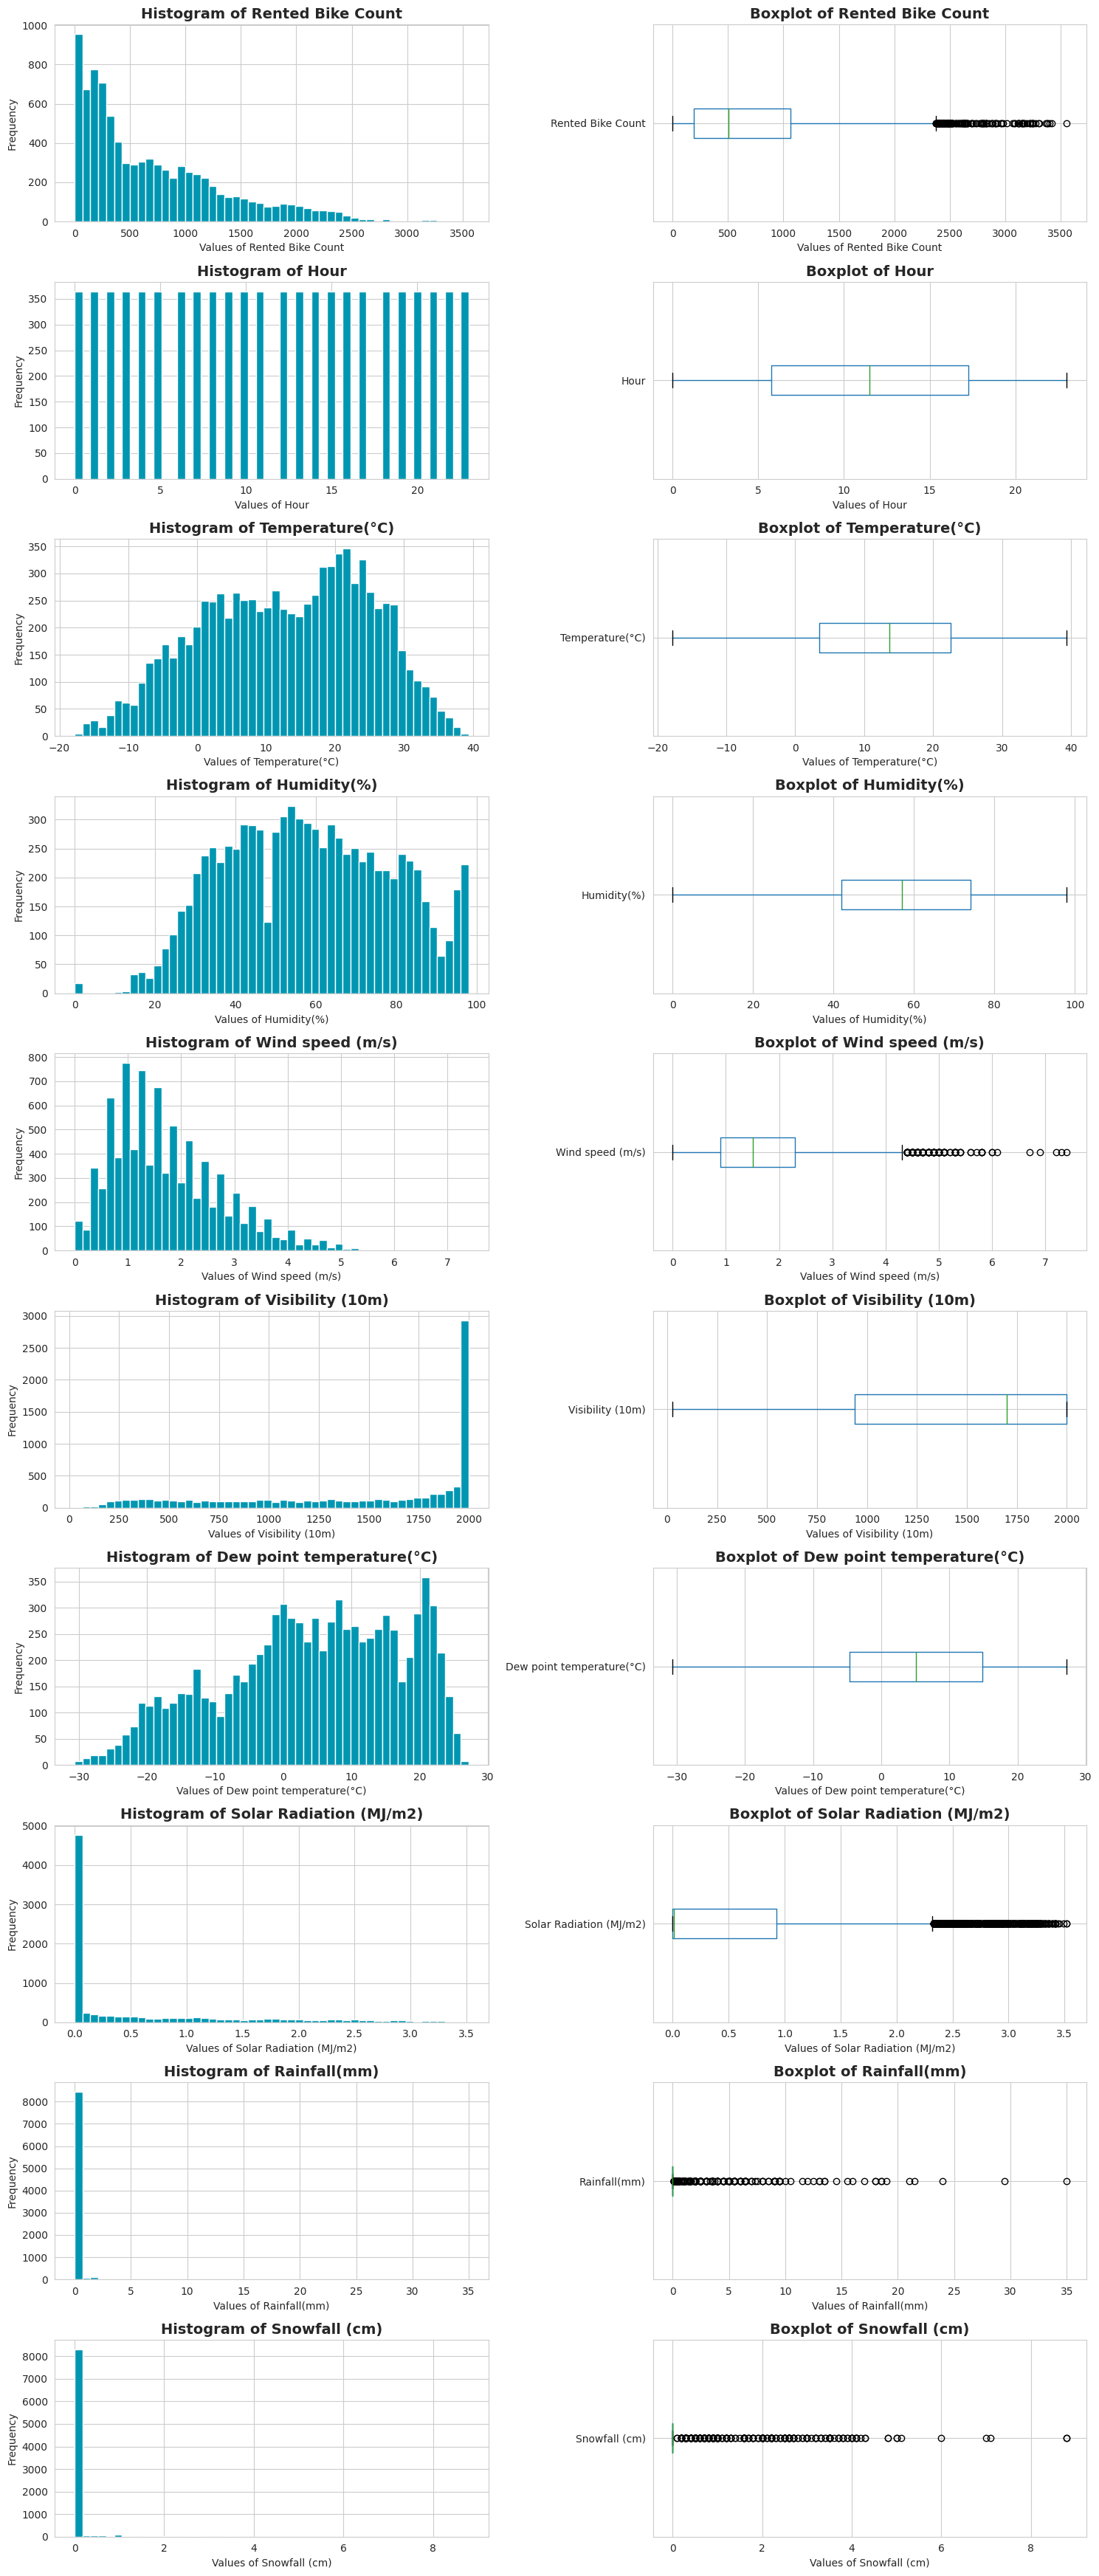

In [ ]:

# Create subplots
fig, axs = plt.subplots(10, 2, figsize=(15, 5*7))

# Loop over each column and plot a histogram and boxplot                                                                                             
for i, column in enumerate(num_col.drop(columns="ID").columns):
    # Histogram
    axs[i, 0].hist(bike_demand[column], bins=50, color='#0096b1')
    axs[i, 0].set_title(f"Histogram of {column}", fontsize=14, fontweight='bold')
    axs[i, 0].set_xlabel(f"Values of {column}")
    axs[i, 0].set_ylabel("Frequency")
    
    # Boxplot
    bike_demand[column].to_frame().boxplot(ax=axs[i, 1], vert=False)
    axs[i, 1].set_title(f"Boxplot of {column}", fontsize=14, fontweight='bold')
    axs[i, 1].set_xlabel(f"Values of {column}")
    axs[i, 1].set_ylabel("");
    
# Adjust subplot spacing
fig.tight_layout()
plt.show();

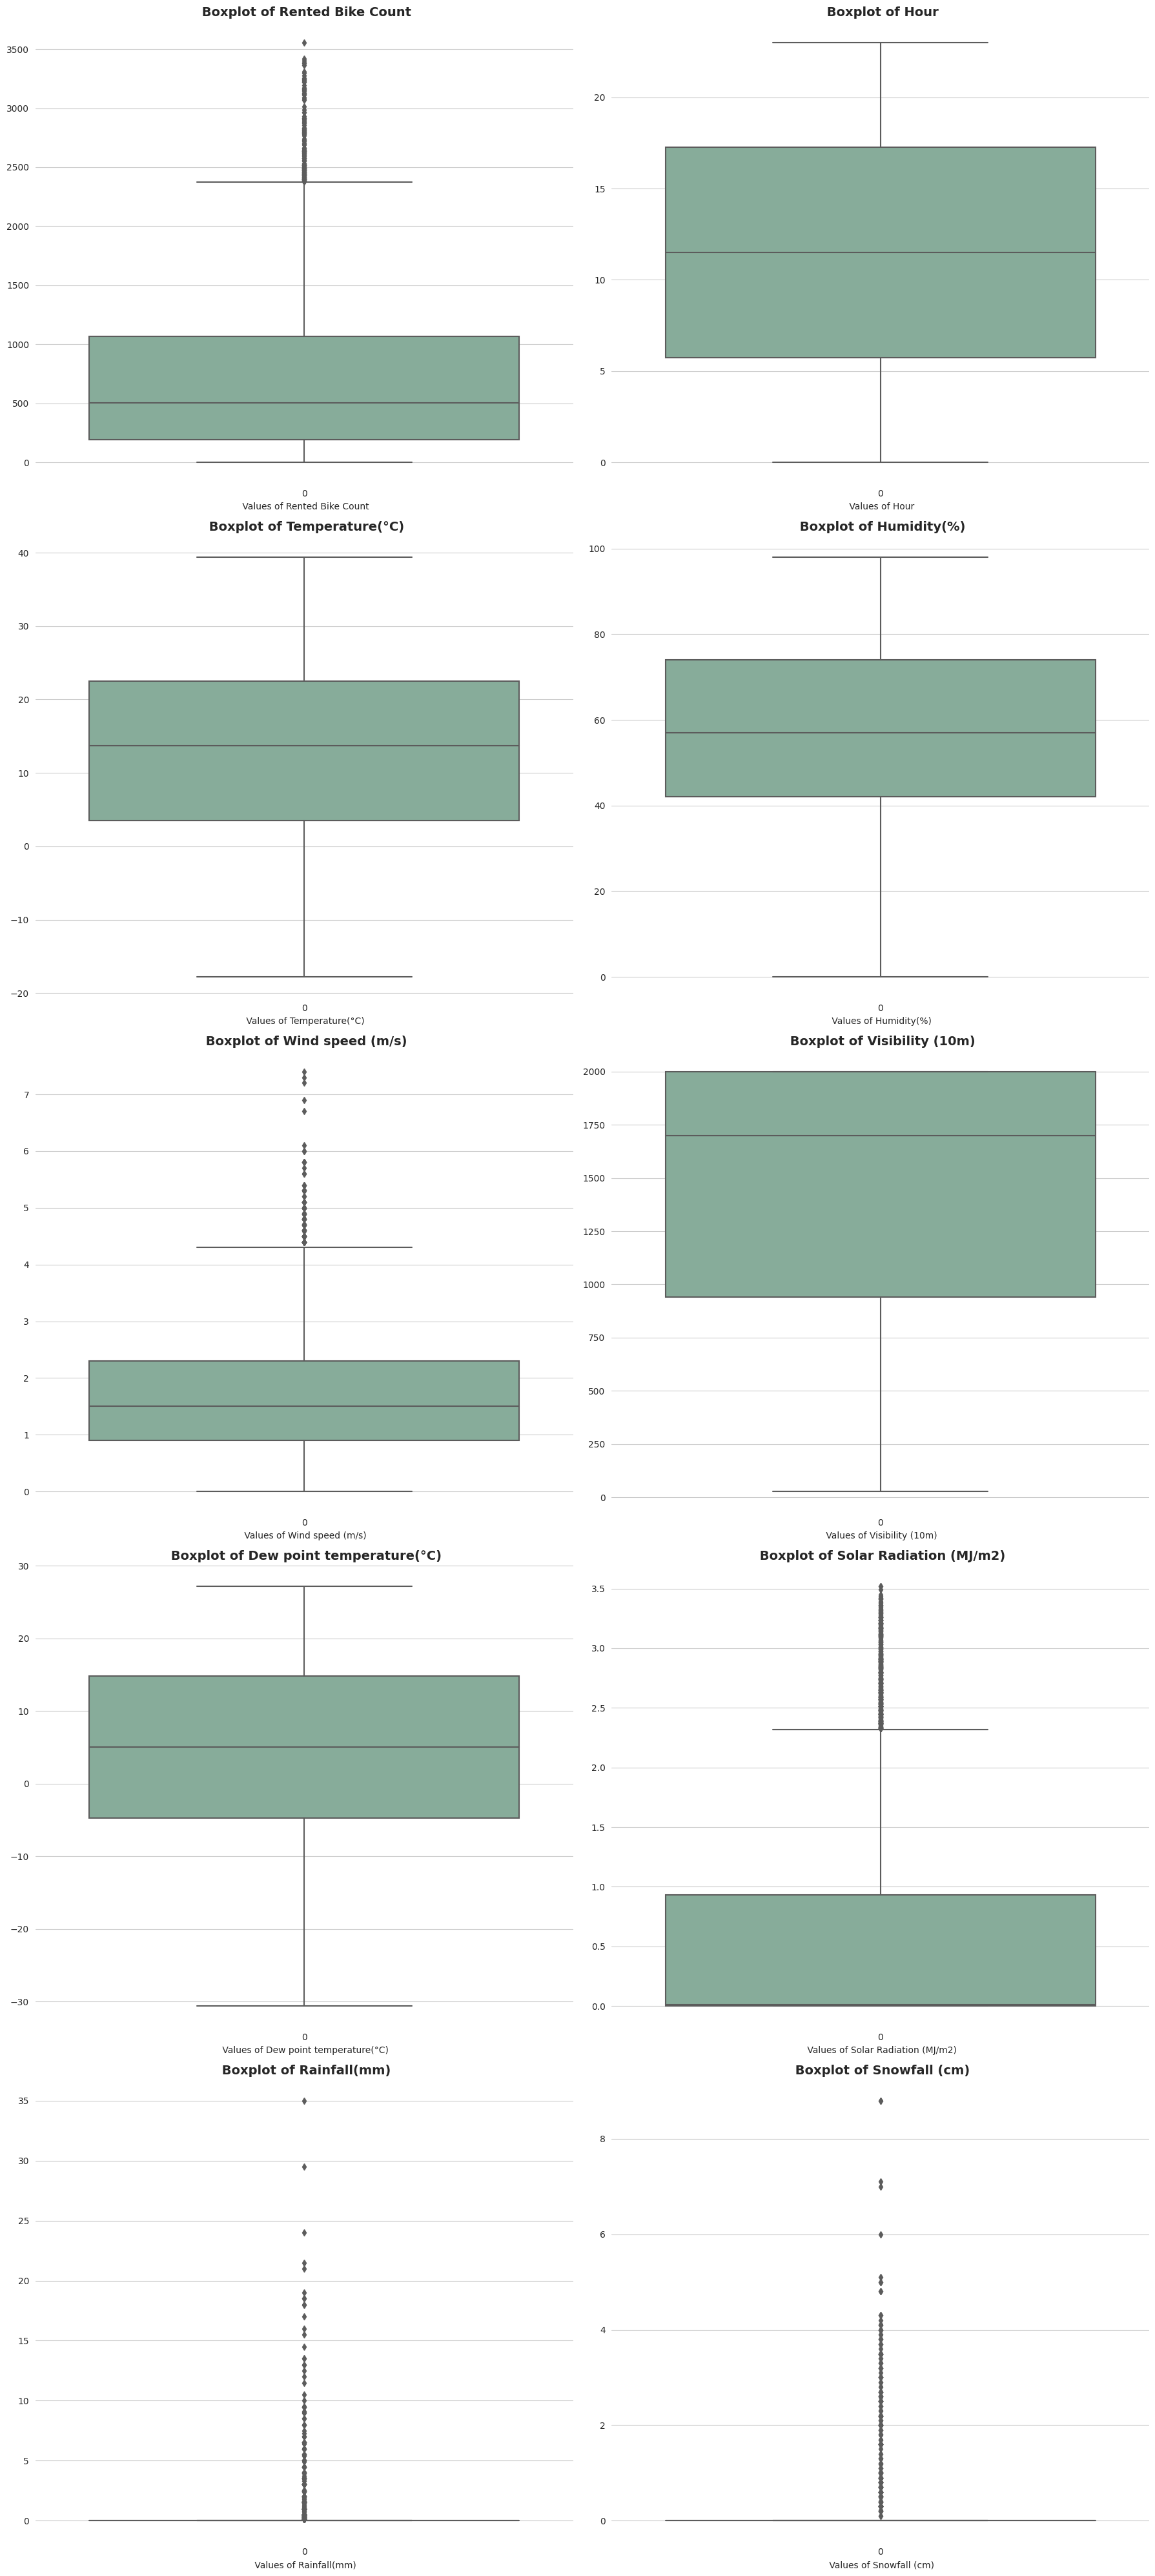